In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
from pyspark.sql import SparkSession
from tqdm import tqdm
import time  # to simulate loading for tqdm

import os
import glob
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType
from pyspark.sql.functions import col, sum as spark_sum, when

In [2]:
spark = SparkSession \
        .builder \
        .config("spark.jars", "jars/gcs-connector-hadoop3-2.2.20-shaded.jar") \
        .getOrCreate()

25/06/13 05:27:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
spark._jsc.hadoopConfiguration().set('fs.gs.impl', 'com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem')
# This is required if you are using service account and set true, 
spark._jsc.hadoopConfiguration().set('fs.gs.auth.service.account.enable', 'true')
spark._jsc.hadoopConfiguration().set('google.cloud.auth.service.account.json.keyfile', "application_default_credentials.json")
# Following are required if you are using oAuth
# spark._jsc.hadoopConfiguration().set('fs.gs.auth.client.id', 'YOUR_OAUTH_CLIENT_ID')
# spark._jsc.hadoopConfiguration().set('fs.gs.auth.client.secret', 'OAUTH_SECRET')

# Load from Bronze Table

In [4]:
# ### Ingesting data from Google Cloud Storage

bucket_name = "cs611_mle"
members_path_in_bucket = "Bronze Layer/bronze_members.csv"
transactions_path_in_bucket = "Silver Layer/silver_transactions.csv"
user_logs_path_in_bucket = "Bronze Layer/df_user_logs.csv"

members_gcs_path = f"gs://{bucket_name}/{members_path_in_bucket}"
transactions_gcs_path = f"gs://{bucket_name}/{transactions_path_in_bucket}"
user_logs_gcs_path = f"gs://{bucket_name}/{user_logs_path_in_bucket}"

# Loading members
for _ in tqdm(range(1), desc="Loading members data"):
    df_members = spark.read.option("header", "true").csv(members_gcs_path)
    time.sleep(0.2)  # simulate a load delay
print("done members!")

# Loading transactions
for _ in tqdm(range(1), desc="Loading transactions data"):
    df_transaction_silver = spark.read.option("header", "true").csv(transactions_gcs_path)
    time.sleep(0.2)
print("done tx silver!")

# Loading user logs
for _ in tqdm(range(1), desc="Loading user logs data"):
    df_user_logs = spark.read.option("header", "true").csv(user_logs_gcs_path)
    time.sleep(0.2)
print("done logs!")

Loading members data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.53s/it]


done members!


Loading transactions data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


done tx silver!


Loading user logs data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]

done logs!


In [5]:
# df_members = pd.read_csv(r'Bronze\Bronze Layer_bronze_members.csv', index_col=0)
# df_members.index.name = None
# df_members.head()

In [6]:
# df_user_logs = pd.read_csv(r'Bronze\Bronze Layer_df_user_logs.csv', index_col=0)
# df_user_logs.index.name = None
# df_user_logs.head()

# Load from Silver Table

In [7]:
# df_transaction_silver = pd.read_csv(r'Silver\Silver Layer_silver_transactions.csv')
# df_transaction_silver.head()

# Load from Gold Table

In [8]:
# df_transaction_gold = pd.read_csv(r'Gold\Gold Layer_labels.csv')
# df_transaction_gold.head()

# EDA

### Bronze Member

In [9]:
df_members.show(5)  # Equivalent to head(), can change 5 to any number

+----------+--------------------+----+---+------+--------------+----------------------+
|Unnamed: 0|                msno|city| bd|gender|registered_via|registration_init_time|
+----------+--------------------+----+---+------+--------------+----------------------+
|   1108581|2dwuk0KQUnCnRvFnD...|   5|  0|female|             9|              20120309|
|   2860696|Bx13MoR+nVJVVDsat...|  13| 33|female|             7|              20130422|
|    685587|2ouWnOhbWxdFyjEy8...|   1|  0|  NULL|             7|              20140629|
|   3381701|QvZtxnHz7yGh07QiF...|  13|  0|  NULL|             9|              20110528|
|   5145811|CUFR22oaKwIwzj4VM...|   5| 42|  male|             9|              20141128|
+----------+--------------------+----+---+------+--------------+----------------------+
only showing top 5 rows



In [10]:
df_members.select([
    spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df_members.columns
]).show()

[Stage 4:=======================================>                   (4 + 2) / 6]

+----------+----+----+---+------+--------------+----------------------+
|Unnamed: 0|msno|city| bd|gender|registered_via|registration_init_time|
+----------+----+----+---+------+--------------+----------------------+
|         0|   0|   0|  0|171532|             0|                     0|
+----------+----+----+---+------+--------------+----------------------+



df_members consists of:
<ul>
    <li>msno = user ID, which is unique to each user and act as the primary key of this table</li>
    <li>city = city number, represented in integer</li>
    <li>gender = the gender of each user, but missing values are found</li>
    <li>registered_via = registration platform number, represented in integer</li>
    <li>registration_init_time = format %Y%m%d</li>
</ul>

In [11]:
# ============ msno =======
df_members.groupBy('msno').count().orderBy('count', ascending=False).show()

[Stage 7:=========>                                                 (1 + 5) / 6]

+--------------------+-----+
|                msno|count|
+--------------------+-----+
|fGKbFFMT2OgrU1LEo...|    1|
|slfXaEbNb+z/vtC97...|    1|
|56eGEJNiqLau6XF2c...|    1|
|YZ8gIl8Dw1sthJ2XH...|    1|
|FvfpM752t9Y1xhcYa...|    1|
|iHFjEZXAMcwjXowhK...|    1|
|rOXR+9d8eAbcHXH14...|    1|
|pQLdihzjKUAmBRtA5...|    1|
|iEkeAUx/4d5CkVSXu...|    1|
|SoSi/WaN1sLDTM+aE...|    1|
|MIUIMcbz6Xgo3k/4P...|    1|
|BpuM8WdIy7hSDKzcs...|    1|
|reb2FdX8ywFLUUrvV...|    1|
|mYbt0P2ohGCPHVXgA...|    1|
|Rn6VZOtNDU3TGmvVE...|    1|
|clUXnw7Y+g76aEBuc...|    1|
|FCmkX11ejjOxqPMFX...|    1|
|ChhWjm1PgGpLHjfzY...|    1|
|VOIOE3HirOaBpGNfe...|    1|
|Shuge+TupRXwOFpZf...|    1|
+--------------------+-----+
only showing top 20 rows



In [12]:
# ============ city =======
city_counts = df_members.groupBy('city').count().orderBy('count', ascending=False)
city_counts.show()

+----+------+
|city| count|
+----+------+
|   1|170876|
|  13| 28413|
|   5| 23388|
|   4| 15424|
|  22| 13012|
|  15| 12703|
|   6|  7911|
|  14|  5908|
|  12|  3761|
|   9|  3049|
|  11|  2689|
|   8|  2472|
|  18|  2347|
|  10|  2080|
|  21|  1583|
|  17|  1579|
|   3|  1538|
|   7|   760|
|  16|   235|
|  20|   219|
+----+------+
only showing top 20 rows



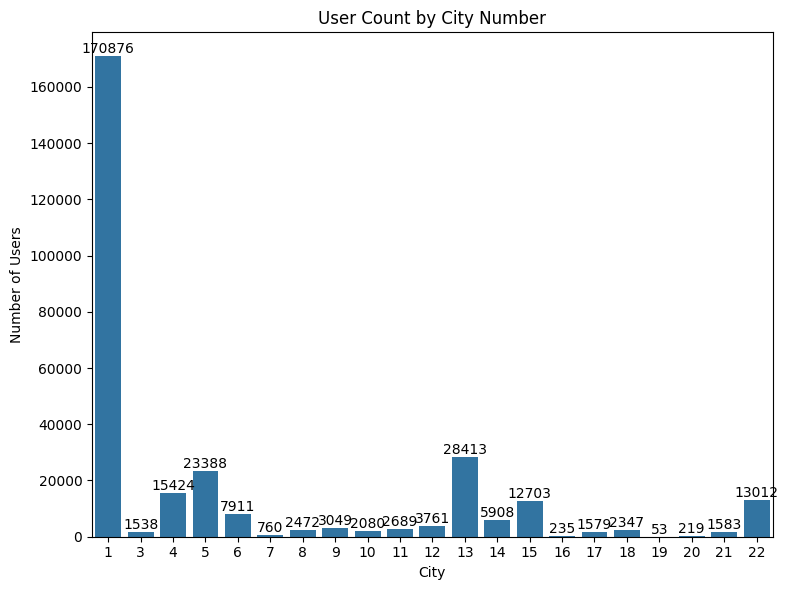

In [13]:
pd_member = df_members.toPandas()
pd_member['city'] = pd_member['city'].astype(int)

# Create plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(pd_member, x = 'city')

# Add count labels on top of bars
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.title('User Count by City Number')
plt.xlabel('City')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

# Some cities has low values in number of users, bucketize low values

In [14]:
# ============ bd/age =======
df_members.groupBy('bd').count().orderBy('count', ascending=False).show()

+---+------+
| bd| count|
+---+------+
|  0|172938|
| 27|  7476|
| 26|  7041|
| 25|  6811|
| 24|  6768|
| 23|  6397|
| 28|  6303|
| 29|  6220|
| 22|  5908|
| 30|  5333|
| 21|  5026|
| 32|  4698|
| 31|  4685|
| 20|  4305|
| 33|  4272|
| 34|  3846|
| 35|  3427|
| 36|  3193|
| 19|  3192|
| 37|  3053|
+---+------+
only showing top 20 rows



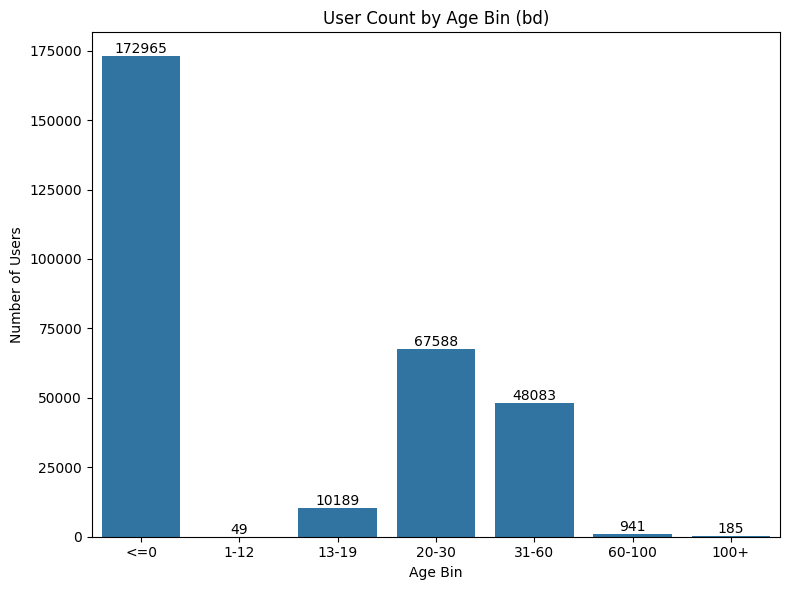

In [15]:
pd_member['bd'] = pd_member['bd'].astype(int)


bins = [-float('inf'), 0, 12, 19, 30, 60, 100, float('inf')]
labels = ['<=0', '1-12', '13-19', '20-30', '31-60', '60-100', '100+']

# Compute temporary binned Series
bd_bin = pd.cut(pd_member['bd'], bins=bins, labels=labels)

# Create plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=bd_bin, order=labels)

# Add count labels on top of bars
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.title('User Count by Age Bin (bd)')
plt.xlabel('Age Bin')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

In [17]:
# Drop age because it has lots of invalid data
df_members = df_members.drop('bd', axis = 1)
df_members.head()

,msno,city,gender,registered_via,registration_init_time
1108581,2dwuk0KQUnCnRvFnDGFyIslHLqG8lFHkyOvfRNwc5XI=,5,female,9,20120309
2860696,Bx13MoR+nVJVVDsatg3fxInFupmO1jSzdkFKMA976t8=,13,female,7,20130422
685587,2ouWnOhbWxdFyjEy8qx/8lr15OzZ0PX9tr6xZP4Ihns=,1,NaN,7,20140629
3381701,QvZtxnHz7yGh07QiFuq0RN1hL5WrzcbKlQTUiroEEyE=,13,NaN,9,20110528
5145811,CUFR22oaKwIwzj4VMey3Mj76B5zawuo2PxsWheNfQ6Q=,5,male,9,20141128


In [18]:
# ============ gender ==============
print(df_members['gender'].unique())
print('Num of Empty rows: ', df_members['gender'].isnull().sum())
df_members['gender'].value_counts()

['female' nan 'male']
Num of Empty rows:  171532


gender
male      65635
female    62833
Name: count, dtype: int64

In [19]:
df_members['gender'] = df_members['gender'].fillna('na')
df_members['gender'].value_counts()

gender
na        171532
male       65635
female     62833
Name: count, dtype: int64

In [20]:
# ============ registered_via ============
print(sorted(df_members['registered_via'].unique()))
df_members['registered_via'].value_counts()

[np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(13), np.int64(14), np.int64(16), np.int64(17), np.int64(19)]


registered_via
7     100050
9      75857
4      67518
3      55475
11       534
13       241
8         91
5         79
17        38
2         34
6         27
16        23
19        20
14        12
10         1
Name: count, dtype: int64

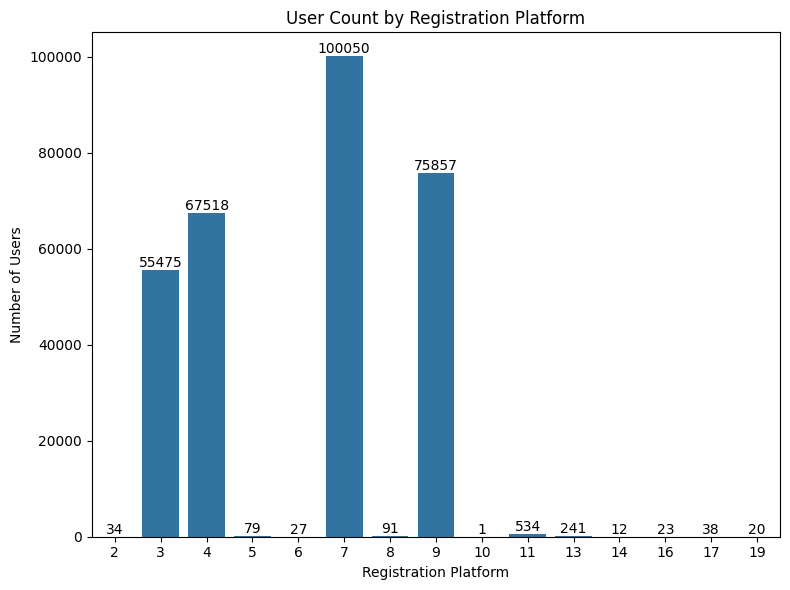

In [21]:
# Create plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(df_members, x = 'registered_via')

# Add count labels on top of bars
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.title('User Count by Registration Platform')
plt.xlabel('Registration Platform')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

# Some platform has low values in number of users, bucketize low values

In [22]:
# ============ registration_init_time ============
df_members['registration_init_time'] = pd.to_datetime(df_members['registration_init_time'], format='%Y%m%d')
df_members.head()

,msno,city,gender,registered_via,registration_init_time
1108581,2dwuk0KQUnCnRvFnDGFyIslHLqG8lFHkyOvfRNwc5XI=,5,female,9,2012-03-09
2860696,Bx13MoR+nVJVVDsatg3fxInFupmO1jSzdkFKMA976t8=,13,female,7,2013-04-22
685587,2ouWnOhbWxdFyjEy8qx/8lr15OzZ0PX9tr6xZP4Ihns=,1,na,7,2014-06-29
3381701,QvZtxnHz7yGh07QiFuq0RN1hL5WrzcbKlQTUiroEEyE=,13,na,9,2011-05-28
5145811,CUFR22oaKwIwzj4VMey3Mj76B5zawuo2PxsWheNfQ6Q=,5,male,9,2014-11-28


In [23]:
df_members['registration_init_time'].describe()

count                        300000
mean     2013-12-16 14:20:44.160000
min             2004-03-26 00:00:00
25%             2012-08-30 00:00:00
50%             2014-08-11 00:00:00
75%             2015-12-31 00:00:00
max             2017-04-29 00:00:00
Name: registration_init_time, dtype: object

### df_user_logs

In [24]:
df_user_logs.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
84,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,20150207,0,0,0,1,54,55,15457.387
85,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,20150522,15,0,0,1,3,14,1227.711
86,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,20151114,6,0,0,0,3,9,782.020
87,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,20160827,0,0,2,0,4,5,1416.413
88,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,20170225,0,0,1,0,5,6,1526.661


In [25]:
# ======== date ============
print(df_user_logs['date'].min())
print(df_user_logs['date'].max())

df_user_logs['date'].describe()

20150101
20170331


count    6.132506e+07
mean     2.015772e+07
std      6.589223e+03
min      2.015010e+07
25%      2.015082e+07
50%      2.016032e+07
75%      2.016092e+07
max      2.017033e+07
Name: date, dtype: float64

In [26]:
df_user_logs['date'] = pd.to_datetime(df_user_logs['date'], format='%Y%m%d')
df_user_logs.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
84,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2015-02-07,0,0,0,1,54,55,15457.387
85,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2015-05-22,15,0,0,1,3,14,1227.711
86,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2015-11-14,6,0,0,0,3,9,782.020
87,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2016-08-27,0,0,2,0,4,5,1416.413
88,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2017-02-25,0,0,1,0,5,6,1526.661


In [27]:
# ========== num_25 ===========
print(df_user_logs['num_25'].min())
print(df_user_logs['num_25'].max())
df_user_logs['num_25'].describe()

0
18798


count    6.132506e+07
mean     6.409505e+00
std      1.600266e+01
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+00
75%      7.000000e+00
max      1.879800e+04
Name: num_25, dtype: float64

<Axes: >

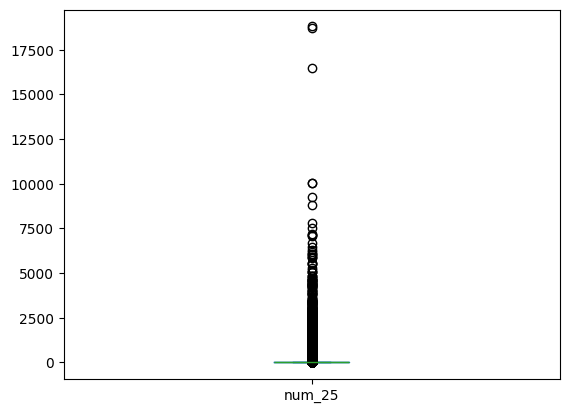

In [28]:
df_user_logs['num_25'].plot(kind='box')

In [29]:
df_user_logs[df_user_logs['num_25'] > 12500] 
# Outliers found
# and found high total secs 

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
68377121,rKYAG23CgaGX50gm+FTNOYlzW+d5RFhsTGfRwahJcrU=,2016-01-09,18798,732,688,1504,3616,1118,1494482.951
310889855,rKYAG23CgaGX50gm+FTNOYlzW+d5RFhsTGfRwahJcrU=,2015-12-21,16465,626,602,1282,3046,1077,1270916.369
391233676,rKYAG23CgaGX50gm+FTNOYlzW+d5RFhsTGfRwahJcrU=,2015-12-31,18733,729,685,1499,3615,1101,1491900.116


In [30]:
# ========== num_50 ===========
print(df_user_logs['num_50'].min())
print(df_user_logs['num_50'].max())
df_user_logs['num_50'].describe()

0
1262


count    6.132506e+07
mean     1.590282e+00
std      4.103806e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.262000e+03
Name: num_50, dtype: float64

<Axes: >

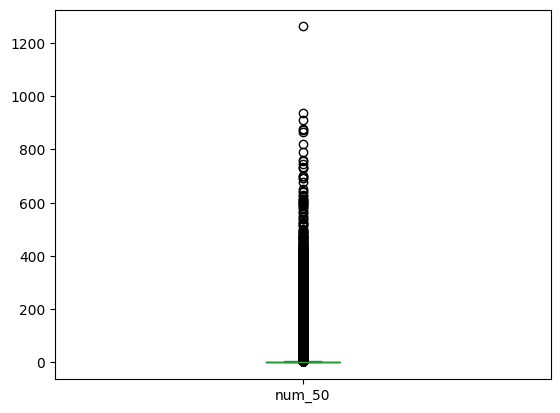

In [31]:
df_user_logs['num_50'].plot(kind='box')

In [32]:
df_user_logs[df_user_logs['num_50'] > 700] 
# Outliers found
# and found high total secs

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
8271147,UEX+mLrHrdvNVyWhtuZc6pwZ7Flk1blYrZPTblSKwV8=,2016-06-10,40,878,157,10,25,1083,110642.671
68377121,rKYAG23CgaGX50gm+FTNOYlzW+d5RFhsTGfRwahJcrU=,2016-01-09,18798,732,688,1504,3616,1118,1494482.951
97130839,QNgOsoH8vYW4oG8/DQ7XSbL6nuyiPPpeRtpJUuHRkZE=,2016-01-22,18,756,1,0,60,66,37085.777
141170418,ekeasY63OvmQVV07dBj3nLRv//ajhfEKpwk264/QK2I=,2016-04-04,145,746,81,15,3,974,83527.655
146578900,mET6TKheEo/3QCyTwIRi6fbbppXGcQ30s9mdHjamEX8=,2015-12-29,466,760,188,25,4,937,115769.371
154019069,SlhrdGRlvKRryBe+rqiWwYBpE1RtuiNLBgVq87At3ig=,2017-02-27,581,938,547,98,64,1792,203545.616
161168012,iwzBdXs+JXTV+HNUIqvH2QDlPo/GFipF2Gd8DYtdId0=,2016-08-16,334,702,202,12,8,1117,95003.532
214502531,Yt0/tZ20o3qWMUhgmjCyIpHpNx16EGD34Xd7UiWIjj8=,2016-08-27,256,872,94,11,7,1142,104657.904
287347075,V0tc4VtZiWQbVJhAyWSiGO2GjLDiEHZJKHegvE3EAH0=,2016-08-09,171,821,160,26,15,1132,102284.799
315083290,ug9mLgENj27p9qsANa5moQ6sACkPXFYjWmVA5n83fgA=,2016-02-21,5,789,3,4,22,13,28870.952


In [33]:
# ========== num_75 ===========
print(df_user_logs['num_75'].min())
print(df_user_logs['num_75'].max())
df_user_logs['num_75'].describe()

0
688


count    6.132506e+07
mean     1.002704e+00
std      2.106944e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      6.880000e+02
Name: num_75, dtype: float64

<Axes: >

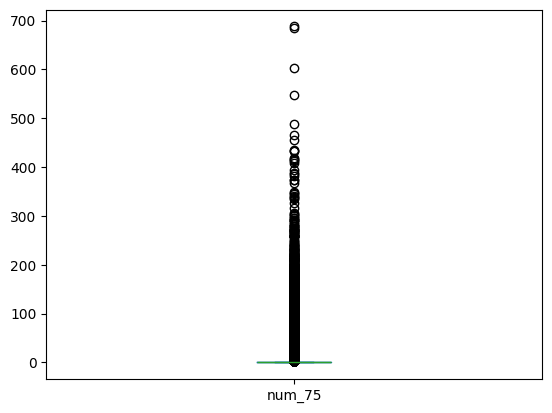

In [34]:
df_user_logs['num_75'].plot(kind='box')

In [35]:
df_user_logs[df_user_logs['num_75'] > 400] 
# Outliers found
# and found high total secs

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
21786086,jFIwWiGrgAsFzSx8A5GGLOkGoQwXf2mzleW0jqKvmfk=,2016-02-03,115,188,434,548,31,1246,213323.725
56919700,Tz719FG9HJ7Em/ypXKT0SEdhnn6ryTcr38Ey6fkcl6E=,2015-10-20,47,109,488,178,40,758,122414.416
68377121,rKYAG23CgaGX50gm+FTNOYlzW+d5RFhsTGfRwahJcrU=,2016-01-09,18798,732,688,1504,3616,1118,1494482.951
90402617,KLU7vNQihy2D9Y6ylD/J7o5iKnq9vzMUwo3ujm231Tg=,2016-02-13,328,424,408,40,35,1139,120227.260
144794526,jFIwWiGrgAsFzSx8A5GGLOkGoQwXf2mzleW0jqKvmfk=,2015-12-20,84,139,466,329,10,977,162065.681
154019069,SlhrdGRlvKRryBe+rqiWwYBpE1RtuiNLBgVq87At3ig=,2017-02-27,581,938,547,98,64,1792,203545.616
223973073,i4/GC0Jfd08UId3Lzv988AxmhcS+vvJLpkjBjce3Mcs=,2016-07-07,56,104,435,198,16,776,126747.210
230132545,i4/GC0Jfd08UId3Lzv988AxmhcS+vvJLpkjBjce3Mcs=,2016-07-08,80,68,415,215,23,741,127033.591
250000735,W9r/0x5PBM3c5xRH0EneNpEsRmQ6GIMaEGOaGvxE7ro=,2015-07-21,368,46,455,139,117,985,134495.218
255834645,MhTMQPgZTx+v6WBRBiwQ+4uWOeEJPUp7RqIAPOOlzEc=,2015-10-14,201,44,417,5,10,276,61747.231


In [36]:
# ========== num_985 ===========
print(df_user_logs['num_985'].min())
print(df_user_logs['num_985'].max())
df_user_logs['num_985'].describe()

0
2747


count    6.132506e+07
mean     1.123061e+00
std      3.181938e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      2.747000e+03
Name: num_985, dtype: float64

<Axes: >

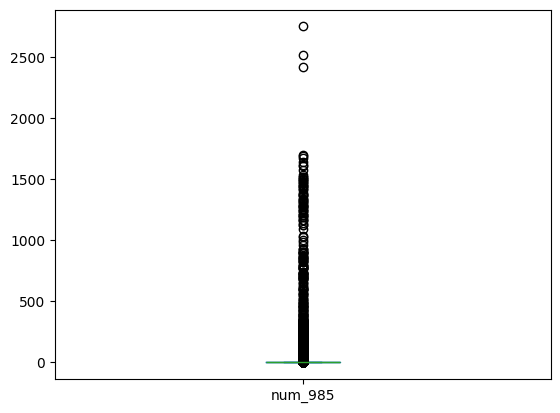

In [37]:
df_user_logs['num_985'].plot(kind='box')

In [38]:
df_user_logs[df_user_logs['num_985'] > 1600] 
# Outliers found
# and found high total secs

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
14283596,enqAew7Ekiu8s3QXlCkB0sn3n9QWjXu5sNyfzLls8GE=,2016-11-28,0,0,0,2417,6,2,49864.000
44119499,enqAew7Ekiu8s3QXlCkB0sn3n9QWjXu5sNyfzLls8GE=,2016-12-02,10,1,0,2516,9,17,52729.625
62368531,76jXST/+vmVgHwOs7oEX42xGTAYin13anGkzj/K7mEg=,2015-04-04,0,0,0,1617,886,3,74927.422
84409088,76jXST/+vmVgHwOs7oEX42xGTAYin13anGkzj/K7mEg=,2015-02-15,0,0,0,1603,1345,3,88374.062
99389718,76jXST/+vmVgHwOs7oEX42xGTAYin13anGkzj/K7mEg=,2015-04-15,0,0,0,1695,1391,3,92483.991
126790358,76jXST/+vmVgHwOs7oEX42xGTAYin13anGkzj/K7mEg=,2015-02-22,0,0,0,2747,2912,3,169357.122
133536527,76jXST/+vmVgHwOs7oEX42xGTAYin13anGkzj/K7mEg=,2015-02-23,0,0,0,1692,1046,3,81965.486
270144847,76jXST/+vmVgHwOs7oEX42xGTAYin13anGkzj/K7mEg=,2015-03-12,0,0,0,1671,1283,3,88615.591
340180364,76jXST/+vmVgHwOs7oEX42xGTAYin13anGkzj/K7mEg=,2015-01-24,0,0,0,1636,1015,3,79433.592


In [39]:
# ========== num_100 ===========
print(df_user_logs['num_100'].min())
print(df_user_logs['num_100'].max())
df_user_logs['num_100'].describe()

0
20172


count    6.132506e+07
mean     3.099070e+01
std      4.130107e+01
min      0.000000e+00
25%      7.000000e+00
50%      1.700000e+01
75%      3.900000e+01
max      2.017200e+04
Name: num_100, dtype: float64

<Axes: >

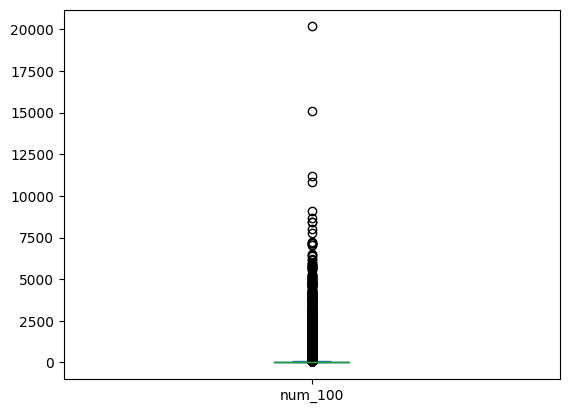

In [40]:
df_user_logs['num_100'].plot(kind='box')

In [41]:
df_user_logs[df_user_logs['num_100'] > 7500] 
# Outliers found
# and found high total secs

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
12725741,bz8tM5vSCAg992wnQSaZFbbG9EWKI1+cXCO9VMNGm+U=,2016-03-22,95,55,34,450,11213,2272,2708302.006
34488539,ZxWDBRckGEs3+L8qWDsXTmTlzki0JqDPQg471Ak3SUs=,2016-07-20,115,19,15,19,7758,978,1576668.576
43840662,aeW+ms5r1+0LHgwkJB3F5f0zSyMWhWo22z4JunnnX0U=,2015-12-19,8,8,2,5,8702,44,1862034.552
142266574,jiEdYmpC+8AENimOlMwe0y1ywh9oAWMzU0apA8jcVj4=,2017-01-01,6,0,2,0,10816,20,2380272.091
147570775,foP1R+vlUmNLN7oOa78fpwOyVJVPwOfNT49zodRTiZo=,2016-06-18,43,1,0,29,15068,510,4005499.353
213915028,76jXST/+vmVgHwOs7oEX42xGTAYin13anGkzj/K7mEg=,2015-06-24,1,2,5,1,9069,9,283863.607
257661414,eSS75Gcs1NmYjATYni3v/pOGigCt2wb3Q6fYMFJJ1cw=,2016-06-27,42,28,21,23,20172,799,4155401.857
302930622,RljgFxE+iLu5nMlGKhdzsF0uV4zP9VAciGmvI73PGTs=,2016-08-03,381,130,104,121,8421,3025,2051992.831
355232336,pLHLxfHn2YrarZwZFGbH5LZcgrCZyaDfb8HKvrixG34=,2016-09-28,2,2,0,0,8419,39,989726.184
16998845,aLZh7PjXmJL2k6ViIPRy6tIJuCeU3F3x+E13zl2w3sQ=,2017-03-22,70,19,13,26,8006,483,1871809.704


In [42]:
# ========== num_unq ===========
print(df_user_logs['num_unq'].min())
print(df_user_logs['num_unq'].max())
df_user_logs['num_unq'].describe()

1
3025


count    6.132506e+07
mean     3.034847e+01
std      3.359219e+01
min      1.000000e+00
25%      8.000000e+00
50%      1.900000e+01
75%      4.000000e+01
max      3.025000e+03
Name: num_unq, dtype: float64

<Axes: >

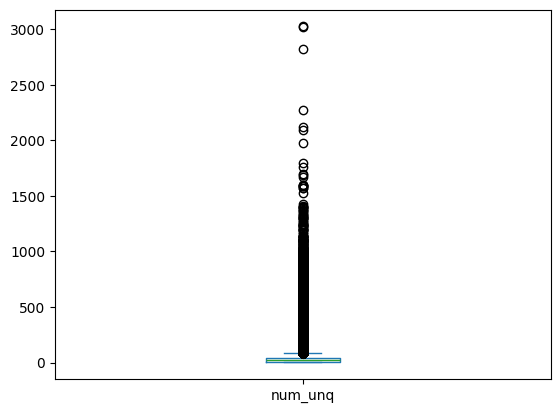

In [43]:
df_user_logs['num_unq'].plot(kind='box')

In [44]:
df_user_logs[df_user_logs['num_unq'] > 1500] 
# Outliers found
# and found high total secs

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
5392059,AkuXvmyjhg3+9bQINKWj1bzmTLStNcRIqaT/xueazog=,2015-11-04,68,30,13,80,2414,1589,585101.069
12725741,bz8tM5vSCAg992wnQSaZFbbG9EWKI1+cXCO9VMNGm+U=,2016-03-22,95,55,34,450,11213,2272,2708302.006
103792086,C23OD8bIL1ixdgT1G4Sm2Rfh2gCY6xNIKQ/lUfbKpSo=,2015-02-08,1419,118,25,8,29,1574,57364.910
122517841,CFaHdyJlruBCq4qkOjwJ8+Uox9KoLn/8yGvX5esnlks=,2016-10-09,3392,28,12,7,52,3018,42443.093
128943620,k7XqJbBHpI9owoBZZteXIFK92KzfuHD/YsogpcET1zg=,2016-05-04,140,22,12,24,2334,1569,606834.684
154019069,SlhrdGRlvKRryBe+rqiWwYBpE1RtuiNLBgVq87At3ig=,2017-02-27,581,938,547,98,64,1792,203545.616
163209833,u0A0nM1bXT3IdnZuQkkp8B7PbJyXSwn1HnL972Xn0sc=,2016-10-10,2680,7,0,5,173,2823,45011.174
221104008,RljgFxE+iLu5nMlGKhdzsF0uV4zP9VAciGmvI73PGTs=,2015-12-22,175,45,46,35,3378,1757,812306.187
230773863,oqr2ReSaecH2+n51JYLndjPwxiEFA2P4/HsEPPfzHr0=,2015-07-18,1504,65,192,11,29,1687,49968.011
278778715,KANU1H1TA4fg0XGPuqr1/zKESwgXbUR1/WjVcHKItRY=,2016-04-26,12,7,5,40,1953,1590,471926.567


In [45]:
# ========== total_secs ===========
print(df_user_logs['total_secs'].min())
print(df_user_logs['total_secs'].max())
df_user_logs['total_secs'].describe()

-9223372036854774.0
9223372036854776.0


count    6.132506e+07
mean    -1.555293e+12
std      1.198189e+14
min     -9.223372e+15
25%      1.985121e+03
50%      4.731149e+03
75%      1.034732e+04
max      9.223372e+15
Name: total_secs, dtype: float64

<Axes: >

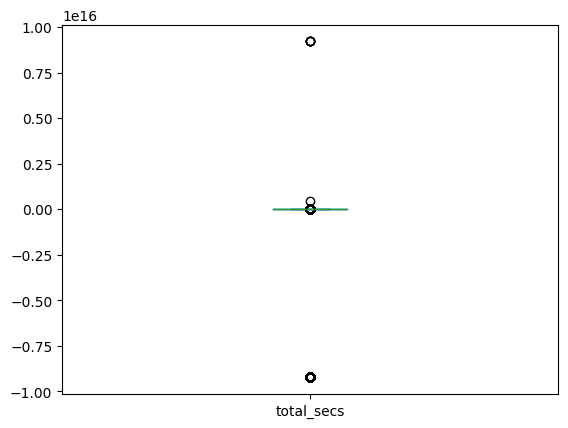

In [46]:
df_user_logs['total_secs'].plot(kind='box')

In [47]:
df_user_logs[df_user_logs['total_secs'] < 0]

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
11600,XoJGWnX0RN5ZUvUTG98Ldj3vlRXNQ3hhIQ1ei63oG7k=,2015-04-30,2,6,0,0,120,118,-9.223372e+15
12969,zCKbAfdXVRoZGSlmLPxQNwL7j9Lea1BbxdmU42SfJxc=,2016-02-21,12,8,8,8,53,77,-9.223372e+15
48791,YHWuzCAur0d5X82+z54TBxou5OnpjydSg/vOgk0QY60=,2015-07-15,50,6,5,2,51,101,-9.223372e+15
59009,gkd3Yd+8ThL5rZJ3qpyKqf4N8H/1oilAxr8WZM7Uicc=,2015-05-13,0,2,0,0,4,5,-9.223372e+15
83785,+cWJuobnNfcWw5iVJL3VHPDrmzfRVX9spY89dLt5UC8=,2015-07-03,0,0,1,2,41,44,-9.223372e+15
...,...,...,...,...,...,...,...,...,...
391960623,8FGK7/WgJfxXZM1qokkBj79V7xsssiXwRuiMJROGSxA=,2015-06-11,4,3,2,1,20,30,-9.223372e+15
391975175,ruS8C/3dlcLWUNbT7DvZKjtgpn/c6pZPTS+sH5pBIAE=,2015-06-25,96,8,2,2,167,158,-9.223372e+15
392007018,wlmvTgOf+azJFtl9wAi+yvumEH8FP1LhUBlheXf9uPw=,2015-05-11,3,0,0,0,35,37,-9.223372e+15
392013597,91jw+VB8UHvRjhJH8Fe1XpQX2eBoEk6oQVRe4MH/Qfo=,2015-08-01,1,0,0,3,88,90,-9.223372e+15


In [48]:
# 1 day = 24 hours = 86400 seconds
df_user_logs[df_user_logs['total_secs'] > 86400].sort_values(by='num_unq')

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
1611401,toUmY6oNxZ6bBJq74Efozfxemsd/3RZWWcZF/PRMAqU=,2015-04-29,0,0,0,0,385,1,107008.055
78869990,lfXJdGoyfjQJU2AdPnVsTNmEmp2Tw08vsZJSnapncWg=,2016-09-23,0,0,0,0,537,1,157924.182
79062393,+lGq1IH+dutnYr+U0gv/4TL42swvjx+i3JMecqSJi1E=,2015-03-03,111,2,16,193,333,1,122924.513
251048612,NFqKG36wABkShFuMNgFJpUdwlE/8WcK08gLwCcgsYko=,2015-10-15,0,0,0,0,308,1,86400.160
15185570,irnqyGOiR7BnH4xDfwPE1MlZNGpLtjYNJ0lJd5lNkdM=,2017-03-03,0,0,0,0,43,1,87032.000
...,...,...,...,...,...,...,...,...,...
154019069,SlhrdGRlvKRryBe+rqiWwYBpE1RtuiNLBgVq87At3ig=,2017-02-27,581,938,547,98,64,1792,203545.616
318202616,CUtZvVbSX2u8slC5hdT9bbvLwXZrS7iBL//b5WuRk9E=,2016-05-23,1910,48,8,4,293,1973,90888.768
318555470,D59O3YPkzg2dVnV7LymhJTGxRyqMaj84sFDTbsYySLU=,2015-12-28,30,10,5,9,4691,2091,1135976.078
12725741,bz8tM5vSCAg992wnQSaZFbbG9EWKI1+cXCO9VMNGm+U=,2016-03-22,95,55,34,450,11213,2272,2708302.006


In [49]:
df_user_logs[df_user_logs['total_secs'] > (0.5*10**16)]

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
41805392,+XCfUxc7QlExHUza/wl6NTq79AjiYkcIb7cRGl4c884=,2015-05-07,0,0,0,0,1,1,9.223372e+15
83841589,sKpCPCQsZcap95MBqEIBD89vNOfbEjCEoJzKr8r/BTk=,2015-06-09,0,0,0,0,1,1,9.223372e+15
113740391,o3D/vuZKd6cmjneawJ45rOgTTjTA/XShmM5BCWh4MEA=,2015-05-06,0,0,0,0,1,1,9.223372e+15
124169684,EYqVF700cpelgkaMaVEodCovRV8t8SZM1bl3Ti0UFKU=,2015-04-24,0,0,0,0,1,1,9.223372e+15
390704160,ggjM+mdXCHxeeXYhk9yw9StrHsDeYjOFOuIECcVctUY=,2015-10-11,0,0,0,0,741,1,9.223372e+15


<Axes: >

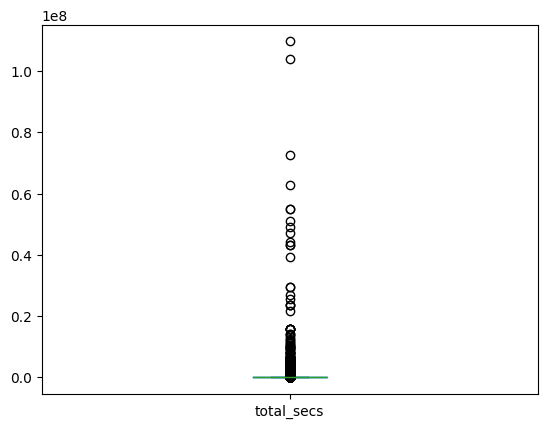

In [50]:
df_user_logs[(df_user_logs['total_secs'] >= 0) & (df_user_logs['total_secs'] < (1.4*10**9))]['total_secs'].plot(kind='box')

### Transaction

In [51]:
df_transaction_silver.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,membership_start_date
0,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-01-08,2015-02-09,0,2015-01-10
1,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-02-08,2015-03-09,0,2015-02-07
2,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-03-08,2015-04-09,0,2015-03-10
3,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-04-08,2015-05-09,0,2015-04-09
4,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,0,0,149,1,2015-05-04,2015-06-04,1,2015-06-04


In [52]:
# === payment method_id ====
print(sorted(df_transaction_silver['payment_method_id'].unique()))
df_transaction_silver['payment_method_id'].value_counts()

[np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]


payment_method_id
41    1847550
40     523088
36     179759
39     174531
37     156567
38      85184
33      46769
34      35789
35      30873
30      23458
31      18839
29      15260
27      14280
32      13959
23       4904
24       4528
28       3955
16       3085
18       2152
20       1435
21       1300
19       1255
26       1195
22       1140
25        634
14        515
17        362
12        355
13        339
10        115
8         102
11         91
15         69
5          33
6          33
3          10
2           4
7           2
4           1
Name: count, dtype: int64

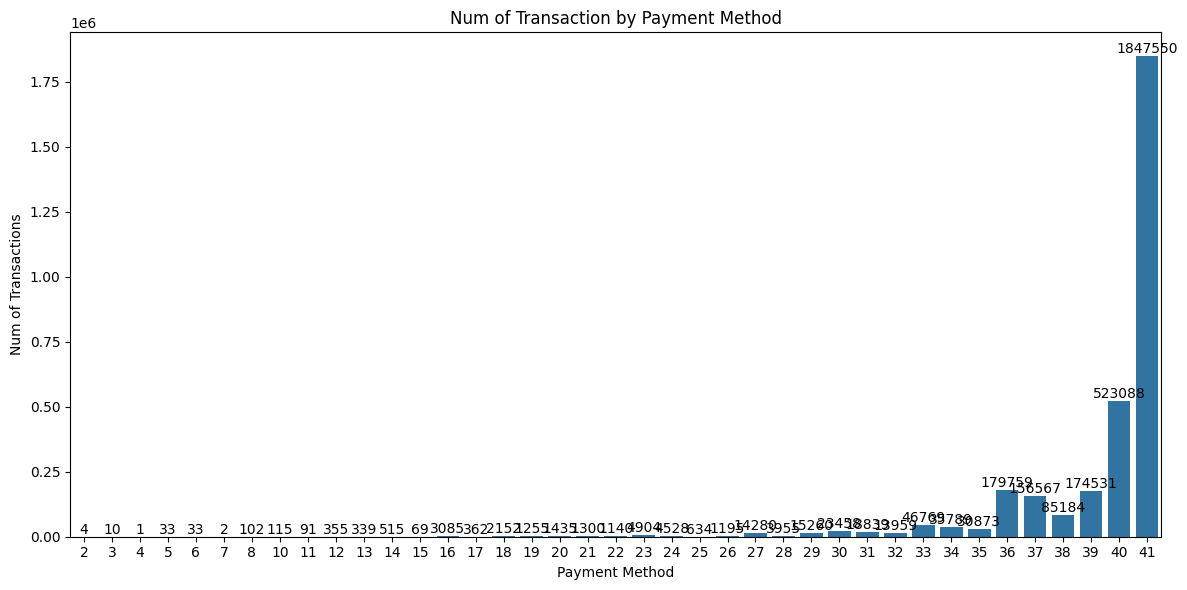

In [53]:
# Create plot
plt.figure(figsize=(12, 6))
ax = sns.countplot(df_transaction_silver, x = 'payment_method_id')

# Add count labels on top of bars
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.title('Num of Transaction by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Num of Transactions')
plt.tight_layout()
plt.show()

# Some payment method has low values in number of users, bucketize low values

In [54]:
# ======== plan_list_price =============
print(df_transaction_silver['plan_list_price'].min())
print(df_transaction_silver['plan_list_price'].max())
df_transaction_silver['plan_list_price'].describe()

0
2000


count    3.193520e+06
mean     1.395479e+02
std      9.311671e+01
min      0.000000e+00
25%      1.290000e+02
50%      1.490000e+02
75%      1.490000e+02
max      2.000000e+03
Name: plan_list_price, dtype: float64

<Axes: >

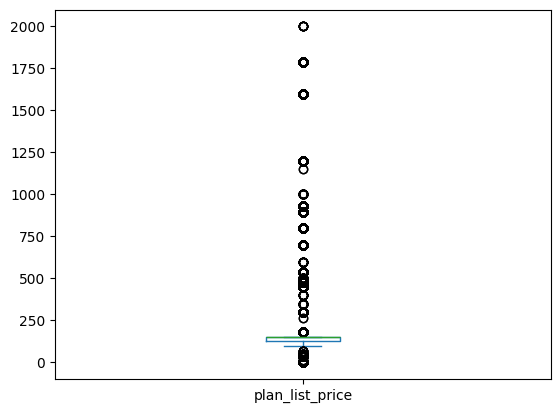

In [55]:
df_transaction_silver['plan_list_price'].plot(kind = 'box')

In [56]:
df_transaction_silver[df_transaction_silver['plan_list_price'] > 1000]

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,membership_start_date
330,++aVm+4v87MXzbhiEXoS7OszzRxcfny8aKalISGUR9I=,32,410,1788,1788,0,2015-12-25,2017-02-07,0,2015-12-25
1368,+/z/GKiqr/+/hls+3tgApsx7iJoNs8dj8rbEFVMxPv8=,32,410,1788,1788,0,2016-02-07,2017-03-26,0,2016-02-10
1473,+04qZA5u8aUoPZ+f5XhZTfyhr/g+RmSVzQXVazlo5Lo=,32,410,1788,1788,0,2015-12-26,2017-02-08,0,2015-12-26
1536,+0ISc0kpp1AoWWDzLGjm7g2W6yqJrVR/dCgcl4+XRn0=,32,410,1788,1788,0,2016-01-04,2017-02-17,0,2016-01-04
2432,+18Oi2vQUf3Yhn+gQnmGMwau3F2e80+2vTMC/V3GYsk=,38,410,1788,1788,0,2015-10-16,2016-11-29,0,2015-10-16
...,...,...,...,...,...,...,...,...,...,...
3192636,zz1UvPLJASJMGqI5ynTpy/f24fD/w8S3R0rgSlHOE04=,22,410,1788,1788,0,2015-05-29,2016-07-17,0,2015-06-03
3192737,zz9azoDBK5uAGKOKMhgekBloqe/sOpL0KicV5zPn66o=,38,410,1788,1788,0,2016-01-29,2017-03-15,0,2016-01-30
3192789,zzFOpF1SheQcQvBjPNPxqzX9Y/frqh3M2HxqMzW7x6w=,32,395,1599,1599,0,2015-12-25,2017-01-25,0,2015-12-27
3193257,zzfex1RO5wKPO6NTGMIJtzB8aNNHdZkwcEo2H6Lt+sk=,32,410,1788,1788,0,2015-02-15,2016-04-05,0,2015-02-20


In [57]:
# ======= actual_amount_paid ============
print(df_transaction_silver['actual_amount_paid'].min())
print(df_transaction_silver['actual_amount_paid'].max())
df_transaction_silver['actual_amount_paid'].describe()

0
2000


count    3.193520e+06
mean     1.423567e+02
std      9.224528e+01
min      0.000000e+00
25%      1.290000e+02
50%      1.490000e+02
75%      1.490000e+02
max      2.000000e+03
Name: actual_amount_paid, dtype: float64

<Axes: >

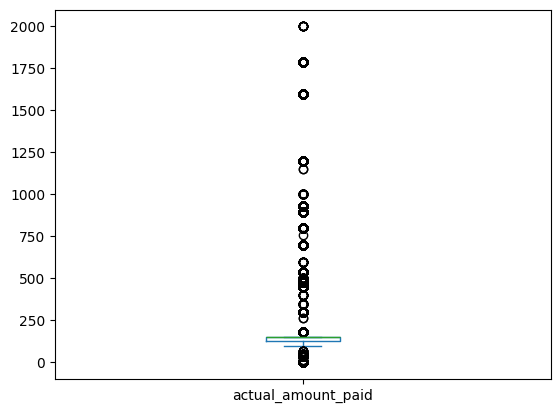

In [58]:
df_transaction_silver['actual_amount_paid'].plot(kind = 'box')

In [59]:
df_transaction_silver[df_transaction_silver['actual_amount_paid'] > 1000]

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,membership_start_date
330,++aVm+4v87MXzbhiEXoS7OszzRxcfny8aKalISGUR9I=,32,410,1788,1788,0,2015-12-25,2017-02-07,0,2015-12-25
1368,+/z/GKiqr/+/hls+3tgApsx7iJoNs8dj8rbEFVMxPv8=,32,410,1788,1788,0,2016-02-07,2017-03-26,0,2016-02-10
1473,+04qZA5u8aUoPZ+f5XhZTfyhr/g+RmSVzQXVazlo5Lo=,32,410,1788,1788,0,2015-12-26,2017-02-08,0,2015-12-26
1536,+0ISc0kpp1AoWWDzLGjm7g2W6yqJrVR/dCgcl4+XRn0=,32,410,1788,1788,0,2016-01-04,2017-02-17,0,2016-01-04
2432,+18Oi2vQUf3Yhn+gQnmGMwau3F2e80+2vTMC/V3GYsk=,38,410,1788,1788,0,2015-10-16,2016-11-29,0,2015-10-16
...,...,...,...,...,...,...,...,...,...,...
3192636,zz1UvPLJASJMGqI5ynTpy/f24fD/w8S3R0rgSlHOE04=,22,410,1788,1788,0,2015-05-29,2016-07-17,0,2015-06-03
3192737,zz9azoDBK5uAGKOKMhgekBloqe/sOpL0KicV5zPn66o=,38,410,1788,1788,0,2016-01-29,2017-03-15,0,2016-01-30
3192789,zzFOpF1SheQcQvBjPNPxqzX9Y/frqh3M2HxqMzW7x6w=,32,395,1599,1599,0,2015-12-25,2017-01-25,0,2015-12-27
3193257,zzfex1RO5wKPO6NTGMIJtzB8aNNHdZkwcEo2H6Lt+sk=,32,410,1788,1788,0,2015-02-15,2016-04-05,0,2015-02-20


In [60]:
# ======= payment plan days ============
print(df_transaction_silver['payment_plan_days'].min())
print(df_transaction_silver['payment_plan_days'].max())
df_transaction_silver['payment_plan_days'].describe()

0
450


count    3.193520e+06
mean     3.025187e+01
std      2.140508e+01
min      0.000000e+00
25%      3.000000e+01
50%      3.000000e+01
75%      3.000000e+01
max      4.500000e+02
Name: payment_plan_days, dtype: float64

<Axes: >

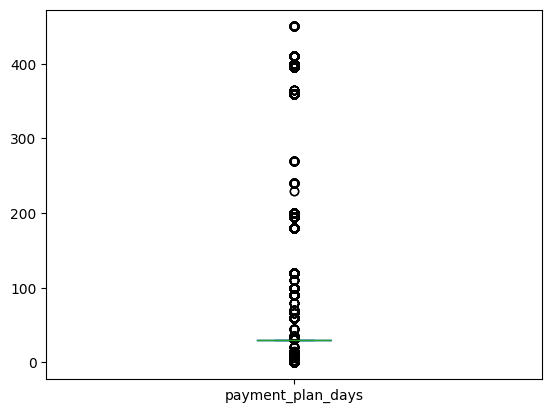

In [61]:
df_transaction_silver['payment_plan_days'].plot(kind = 'box')

In [62]:
# ========= is_auto_renew ===========
print(df_transaction_silver['is_auto_renew'].min())
print(df_transaction_silver['is_auto_renew'].max())
df_transaction_silver['is_auto_renew'].describe()

0
1


count    3.193520e+06
mean     9.265021e-01
std      2.609521e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: is_auto_renew, dtype: float64

In [63]:
# ======= transaction_date ============
print(df_transaction_silver['transaction_date'].min())
print(df_transaction_silver['transaction_date'].max())
df_transaction_silver['transaction_date'].describe()

2015-01-01
2017-03-31


count        3193520
unique           821
top       2015-03-31
freq           21582
Name: transaction_date, dtype: object

In [64]:
# ======= membership_start_date ============
print(df_transaction_silver['membership_start_date'].min())
print(df_transaction_silver['membership_start_date'].max())
df_transaction_silver['membership_start_date'].describe()

2015-01-01
2017-03-31


count        3193520
unique           821
top       2015-06-08
freq           14571
Name: membership_start_date, dtype: object

In [65]:
# ======= membership_expire_date ============
print(df_transaction_silver['membership_expire_date'].min())
print(df_transaction_silver['membership_expire_date'].max())
df_transaction_silver['membership_expire_date'].describe()

2015-01-12
2017-03-31


count        3193520
unique           797
top       2017-02-28
freq           12550
Name: membership_expire_date, dtype: object

In [66]:
# ========= is_cancel ===========
print(df_transaction_silver['is_cancel'].min())
print(df_transaction_silver['is_cancel'].max())
df_transaction_silver['is_cancel'].describe()

0
1


count    3.193520e+06
mean     5.665285e-02
std      2.311781e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: is_cancel, dtype: float64

# Feature Engineering

### Transaction

In [67]:
# Bucketize payment method id
df_transaction_silver['payment_method_id'].value_counts()

payment_method_id
41    1847550
40     523088
36     179759
39     174531
37     156567
38      85184
33      46769
34      35789
35      30873
30      23458
31      18839
29      15260
27      14280
32      13959
23       4904
24       4528
28       3955
16       3085
18       2152
20       1435
21       1300
19       1255
26       1195
22       1140
25        634
14        515
17        362
12        355
13        339
10        115
8         102
11         91
15         69
5          33
6          33
3          10
2           4
7           2
4           1
Name: count, dtype: int64

In [68]:
df_transaction_silver['payment_method_id'] = df_transaction_silver['payment_method_id'].apply( lambda x: x if x in range(36, 42) else 'Others' )
df_transaction_silver['payment_method_id'].value_counts()

payment_method_id
41        1847550
40         523088
Others     226841
36         179759
39         174531
37         156567
38          85184
Name: count, dtype: int64

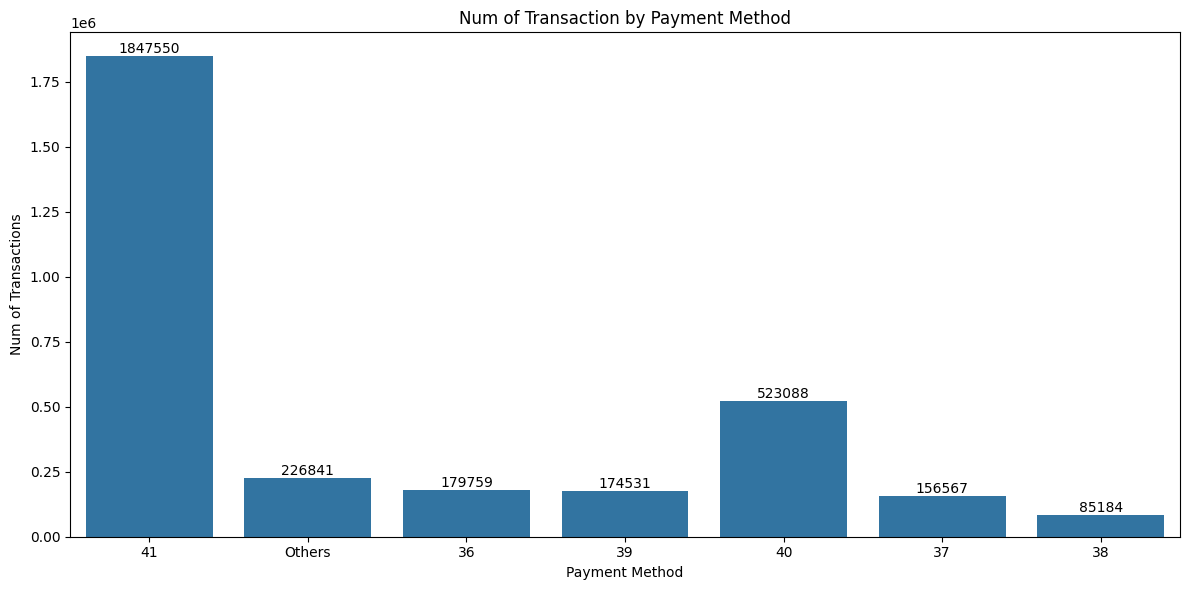

In [69]:
# Create plot
plt.figure(figsize=(12, 6))
ax = sns.countplot(df_transaction_silver, x = 'payment_method_id')

# Add count labels on top of bars
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.title('Num of Transaction by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Num of Transactions')
plt.tight_layout()
plt.show()

In [70]:
df_transaction_silver['discount_ratio'] = np.where(
    df_transaction_silver['plan_list_price'] != 0,
    (df_transaction_silver['plan_list_price'] - df_transaction_silver['actual_amount_paid']) / df_transaction_silver['plan_list_price'],
    0
)

In [71]:
df_transaction_silver['discount_ratio'].value_counts()

discount_ratio
 0.000000    3064398
 0.201342      90733
 1.000000      37623
 0.134228        531
 0.335570        210
-0.252101         23
-0.007937          2
Name: count, dtype: int64

In [72]:
# df_transaction_silver[df_transaction_silver['discount_ratio'] < 0]['is_cancel'].value_counts()

In [73]:
# df_transaction_silver[df_transaction_silver['discount_ratio'] == 1]['discount_rate'].value_counts()

In [74]:
df_transaction_silver.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,membership_start_date,discount_ratio
0,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-01-08,2015-02-09,0,2015-01-10,0.0
1,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-02-08,2015-03-09,0,2015-02-07,0.0
2,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-03-08,2015-04-09,0,2015-03-10,0.0
3,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-04-08,2015-05-09,0,2015-04-09,0.0
4,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,0,0,149,1,2015-05-04,2015-06-04,1,2015-06-04,0.0


In [75]:
df_transaction_silver.to_csv('Silver Layer_silver_transactions_FE.csv', index=False)

## <b> Transaction Silver Issues to be addressed: </b>
<ol>
    <li><b>actual amount paid (or plan_list_price)</b> will be deleted later!</li>
    <li><b>payment method id</b> has been binned/bucketized, Risk of Data Leakage</li>
    <li><b>discount rate </b>= (1 - (df_transaction_silver['actual_amount_paid']/df_transaction_silver['plan_list_price'])) if df_transaction_silver['plan_list_price'] == 0 else 0<br/>but some discount rate has negative values, cause by plan_list_price < actual_amount_paid, and plan_list_price != 0</li>
        <li><b>payment_plan_days</b> some are not 30 or 31 days</li>
</ol>

### User Logs

In [85]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType

print('Done!')

# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

Done!


In [ ]:
# Convert to PySpark DataFrames
spark_user_logs = spark.createDataFrame(df_user_logs)
print('done user logs')
spark_transactions = spark.createDataFrame(df_transactions)
print('done tx')

In [ ]:
spark_user_logs

In [76]:
df_user_logs.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
84,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2015-02-07,0,0,0,1,54,55,15457.387
85,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2015-05-22,15,0,0,1,3,14,1227.711
86,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2015-11-14,6,0,0,0,3,9,782.020
87,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2016-08-27,0,0,2,0,4,5,1416.413
88,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2017-02-25,0,0,1,0,5,6,1526.661


In [77]:
df_user_logs[df_user_logs['msno'] == 'mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4='].head(10).sort_values(by='date')

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
84,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2015-02-07,0,0,0,1,54,55,15457.387
14348417,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2015-02-08,0,0,1,0,14,15,4250.033
22344793,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2015-02-10,19,1,0,0,1,19,402.101
85,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2015-05-22,15,0,0,1,3,14,1227.711
14348418,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2015-05-31,11,0,0,0,0,9,65.626
86,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2015-11-14,6,0,0,0,3,9,782.020
14348419,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2015-11-19,28,1,0,3,1,29,1180.717
87,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2016-08-27,0,0,2,0,4,5,1416.413
14348420,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2016-09-03,7,0,0,2,65,71,17871.646
88,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2017-02-25,0,0,1,0,5,6,1526.661


In [78]:
# """
# each membership period
# 1. sum_songs = sum(num_25 + num_50 + num_75 + ..)
# 2. sum_total_seconds_per_day = sum(total_seconds_day1 + 2 + 3)

# 4. avg_secs_per_song = total_secs_played/sum_songs
# 5. last_first_7_days_total_secs_ratio = (total_secs_last_7_days/total_secs_first_7_days)
# 6. avg unique song played ratio (n_unique/sum_songs) per day
# 7. avg songs_played_25%_ratio = (num_25/sum_songs) per day
# 8. avg songs_played_50%_ratio = (num_50/sum_songs) per day
# 9 avg songs_played_75%_ratio = (num_75/sum_songs) per day
# 10. avg songs_played_985%_ratio = (num_985/sum_songs) per day
# 11. avg songs_played_100%_ratio = (num_100/sum_songs) per day
# 12. skip_ratio = (num_25 + num_50) / total_songs_played

# joined with tx (to get msno, start membership, expire membership)
# """

In [77]:
df_user_logs_silver = df_transaction_silver[['msno', 'membership_start_date', 'membership_expire_date']]
df_user_logs_silver.head()

,msno,membership_start_date,membership_expire_date
0,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,2015-01-10,2015-02-09
1,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,2015-02-07,2015-03-09
2,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,2015-03-10,2015-04-09
3,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,2015-04-09,2015-05-09
4,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,2015-06-04,2015-06-04


In [79]:
df_user_logs_silver.info()

NameError: name 'df_user_logs_silver' is not defined

In [ ]:
# rows = []

# for index, row in df_transaction_silver.iterrows():
#     msno = row['msno']
#     print('done msno')
#     start_date = row['membership_start_date']
#     print('start date')
#     end_date = row['membership_expire_date']
#     print('expr')

#     logs = df_user_logs[(df_user_logs['msno'] == msno) & (df_user_logs['date'] >= start_date) & (df_user_logs['date'] <= end_date)]

#     sum_songs = logs[['num_25', 'num_50', 'num_75', 'num_985', 'num_100']].sum().sum()
#     total_secs = logs['total_secs'].sum()
#     active_days = logs['date'].nunique()

#     avg_secs_per_song = total_secs / sum_songs if sum_songs > 0 else 0

#     rows.append({
#         'msno': msno,
#         'membership_start_date': start_date,
#         'membership_expire_date': end_date,
#         'sum_songs': sum_songs,
#         'total_secs': total_secs,
#         'active_days': active_days,
#         'avg_secs_per_song': avg_secs_per_song
#     })

# testing_for_df = pd.DataFrame(rows)
# testing_for_df

### Member

In [90]:
df_members.head()

,msno,city,gender,registered_via,registration_init_time
1108581,2dwuk0KQUnCnRvFnDGFyIslHLqG8lFHkyOvfRNwc5XI=,5,female,9,2012-03-09
2860696,Bx13MoR+nVJVVDsatg3fxInFupmO1jSzdkFKMA976t8=,13,female,7,2013-04-22
685587,2ouWnOhbWxdFyjEy8qx/8lr15OzZ0PX9tr6xZP4Ihns=,1,na,7,2014-06-29
3381701,QvZtxnHz7yGh07QiFuq0RN1hL5WrzcbKlQTUiroEEyE=,13,na,9,2011-05-28
5145811,CUFR22oaKwIwzj4VMey3Mj76B5zawuo2PxsWheNfQ6Q=,5,male,9,2014-11-28


In [91]:
# Account age on transaction x member registration init time